# Web APIs & NLP: Reddit classification
### Notebook 02 - Data Cleaning/EDA and Preprocessing


_Author: Joe Serigano (jserigano4@gmail.com)_

---

**Objectives:**
- Combine subreddit DataFrames and binarize subreddit column for use as y-variable in NLP modelling.
- Remove stop words and perform EDA on remaining title words.
- Export cleaned data for NLP modelling.

In [1]:
# Import libaries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# We are dealing with large data sets, so setting max number of column and row displays to be unlimited
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Read in and concatenate DataFrames saved from Notebook 1
df_lpt = pd.read_csv('data/lifeprotips.csv')
df_slpt = pd.read_csv('data/shittylifeprotips.csv')

df = pd.concat([df_lpt, df_slpt])

In [3]:
df.head()

,subreddit,title
0,LifeProTips,If you are as outraged as I am about the overt...
1,LifeProTips,Doing things when you don't want to do them is...
2,LifeProTips,Dedicate a credit card to only subscription se...
3,LifeProTips,Like to have a flutter but gambling is too exp...
4,LifeProTips,Enraged by RvW and feeling powerless? Consider...


In [4]:
# Check for null values
df.isnull().sum()

subreddit    0
title        2
dtype: int64

In [5]:
# Drop null values
df.dropna(inplace = True)

In [6]:
df['subreddit'].value_counts(normalize = True)

LifeProTips          0.504693
ShittyLifeProTips    0.495307
Name: subreddit, dtype: float64

The above value is our baseline accuracy for our null model, which is just predicting the plurality class each time. Our baseline accuracy to beat is 50.5% in this case.

Next, we will binarize our subreddit column. r/LifeProTips will be 1 and r/ShittyLifeProTips will be 0. 

In [7]:
df['subreddit'] = df['subreddit'].map({'LifeProTips':1,'ShittyLifeProTips':0})

## EDA:

We'll compare the word count and top words for each subreddit.

In [8]:
# Determine word count for each title
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split(' ')))

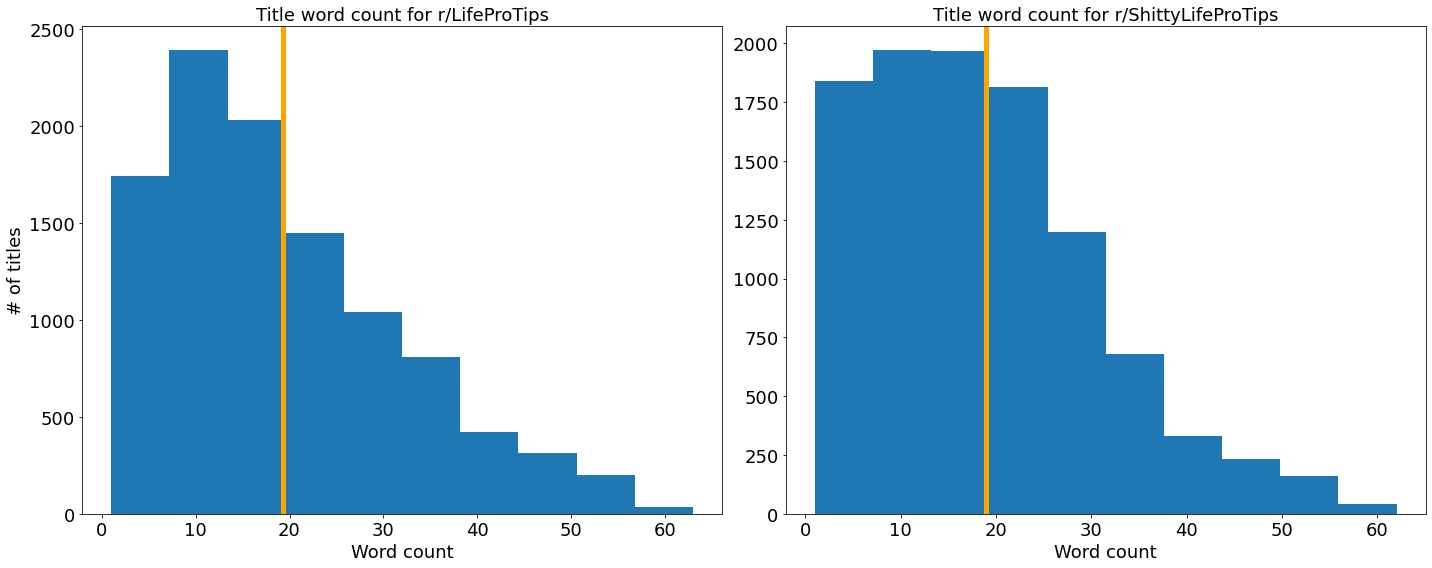

In [27]:
fsize = 18
plt.figure(figsize = (20,8))

ax1 = plt.subplot(1, 2, 1)
df[df['subreddit'] == 1]['title_word_count'].hist(grid = False)
plt.axvline(df[df['subreddit'] == 1]['title_word_count'].mean(), color = 'orange',  lw = 5)
ax1.set_xlabel('Word count',fontsize = fsize)
ax1.set_ylabel('# of titles',fontsize = fsize)
plt.title('Title word count for r/LifeProTips', fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize);

ax2 = plt.subplot(1, 2, 2)
df[df['subreddit'] == 0]['title_word_count'].hist(grid = False)
plt.axvline(df[df['subreddit'] == 0]['title_word_count'].mean(), color = 'orange',  lw = 5)
ax2.set_xlabel('Word count',fontsize = fsize)
plt.title('Title word count for r/ShittyLifeProTips', fontsize = fsize)
plt.xticks(fontsize = fsize)
plt.yticks(fontsize = fsize);
plt.tight_layout()
plt.savefig('figures/word_count.png',facecolor = 'white')

Both subreddits have a very similar distribution in word count and they actually have the same average word count of 19 words. So, unfortunately word count likely won't be very useful as a feature in our model.

Next, we'll create a function to plot the top words for each subreddit. The function takes n_min and n_max as a parameter, so we can look at the most popular unigrams, bigrams, trigrams, etc.

I'm more interested in bigrams than unigrams, so let's look at these:

In [10]:
def plot_top_words(subreddit_name, subreddit_num, title, n_min, n_max, n_words):
    X = df[df['subreddit'] == subreddit_num][title]
    cvec = CountVectorizer(ngram_range = (n_min,n_max), stop_words='english').fit(X)
    X = cvec.transform(X)
    X_cvec = pd.DataFrame(X.todense(), columns = cvec.get_feature_names_out())
    fsize = 18
    plt.figure(figsize = (10,10))
    X_cvec.sum().sort_values(ascending = False).head(n_words).plot(kind = 'barh');
    plt.title(f'Top words in {subreddit_name}', fontsize = fsize)
    plt.xlabel('Number of occurrences', fontsize = fsize)
    plt.xticks(fontsize = fsize)
    plt.yticks(fontsize = fsize)
    plt.tight_layout()
    figname = 'figures/'+subreddit_name+'.png'
    plt.savefig(figname,facecolor = 'white')

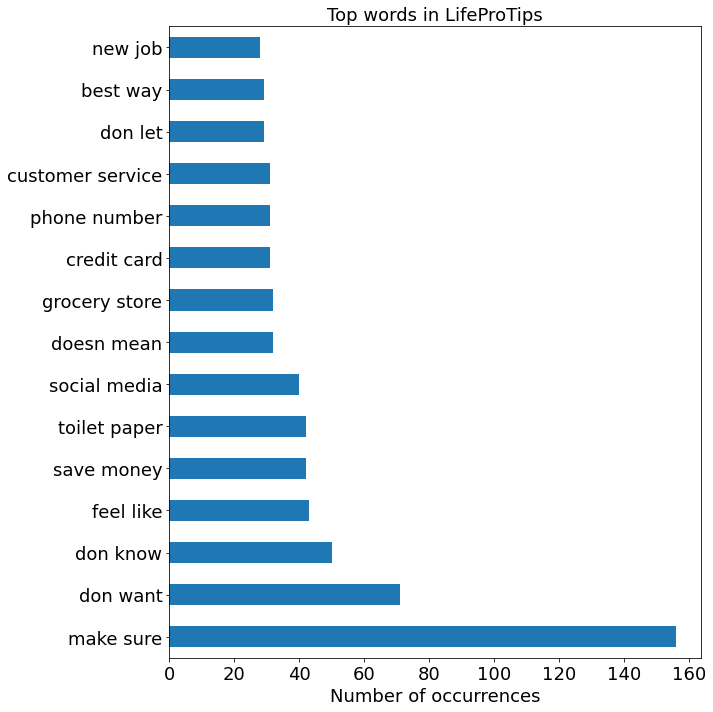

In [11]:
plot_top_words('LifeProTips', 1, 'title', 2, 2, 15)

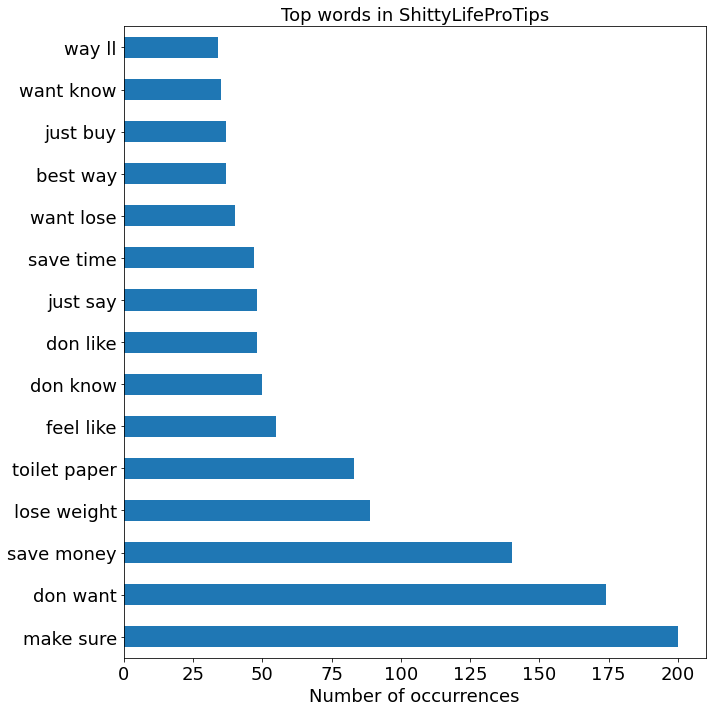

In [12]:
plot_top_words('ShittyLifeProTips',0, 'title', 2, 2, 15)

We can see that the top bigrams have a lot of overlap...this doesn't bode well for trying to create a model that can accurately predict the subreddit a title originaly came from!

Let's create cleaned, lemmatized, and stemmed versions of the titles and see if this changes the top occurrences. 

In [13]:
# Creating titles free of stop words
df['title_clean'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

In [14]:
df.head()

,subreddit,title,title_word_count,title_clean
0,1,If you are as outraged as I am about the overt...,24,"If outraged I overturning Roe v Wade, join mak..."
1,1,Doing things when you don't want to do them is...,32,"Doing things want skill practice, take advanta..."
2,1,Dedicate a credit card to only subscription se...,21,Dedicate credit card subscription services. If...
3,1,Like to have a flutter but gambling is too exp...,12,Like flutter gambling expensive? Try ‘micro-ga...
4,1,Enraged by RvW and feeling powerless? Consider...,21,Enraged RvW feeling powerless? Consider joinin...


In [15]:
# Function for lemmatizing
def lemmatize_title(title):

    # split into words
    split_title = title.split()

    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # lemmatize and rejoin
    return ' '.join([lemmatizer.lemmatize(word) for word in split_title])


In [16]:
def stem_title(title):

    # split into words
    split_title = title.split()
    
    # instantiate stemmer
    stemmer = PorterStemmer()

    # stem and rejoin
    return ' '.join([stemmer.stem(word) for word in split_title])

In [17]:
df['title_lemm'] = df['title_clean'].apply(lemmatize_title)
df['title_stem'] = df['title_clean'].apply(stem_title)

In [18]:
df.head()

,subreddit,title,title_word_count,title_clean,title_lemm,title_stem
0,1,If you are as outraged as I am about the overt...,24,"If outraged I overturning Roe v Wade, join mak...","If outraged I overturning Roe v Wade, join mak...","if outrag i overturn roe v wade, join make don..."
1,1,Doing things when you don't want to do them is...,32,"Doing things want skill practice, take advanta...","Doing thing want skill practice, take advantag...","do thing want skill practice, take advantag ti..."
2,1,Dedicate a credit card to only subscription se...,21,Dedicate credit card subscription services. If...,Dedicate credit card subscription services. If...,dedic credit card subscript services. if see u...
3,1,Like to have a flutter but gambling is too exp...,12,Like flutter gambling expensive? Try ‘micro-ga...,Like flutter gambling expensive? Try ‘micro-ga...,like flutter gambl expensive? tri ‘micro-gambl...
4,1,Enraged by RvW and feeling powerless? Consider...,21,Enraged RvW feeling powerless? Consider joinin...,Enraged RvW feeling powerless? Consider joinin...,enrag rvw feel powerless? consid join the sata...


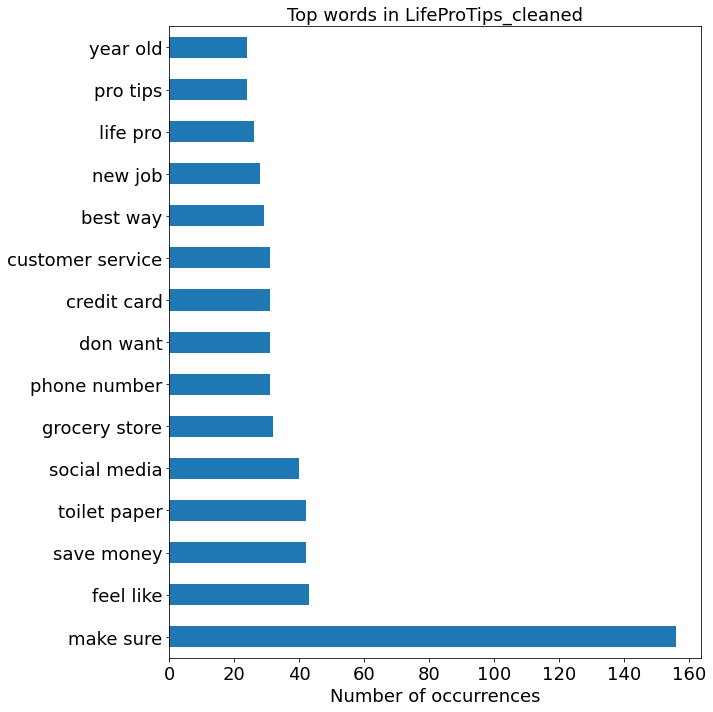

In [19]:
plot_top_words('LifeProTips_cleaned',1, 'title_clean', 2, 2, 15)

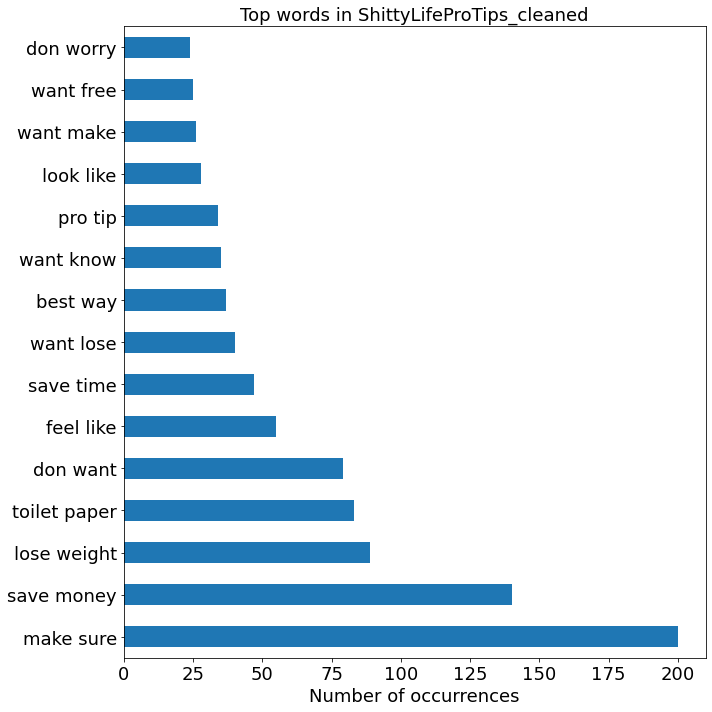

In [20]:
plot_top_words('ShittyLifeProTips_cleaned',0, 'title_clean', 2, 2, 15)

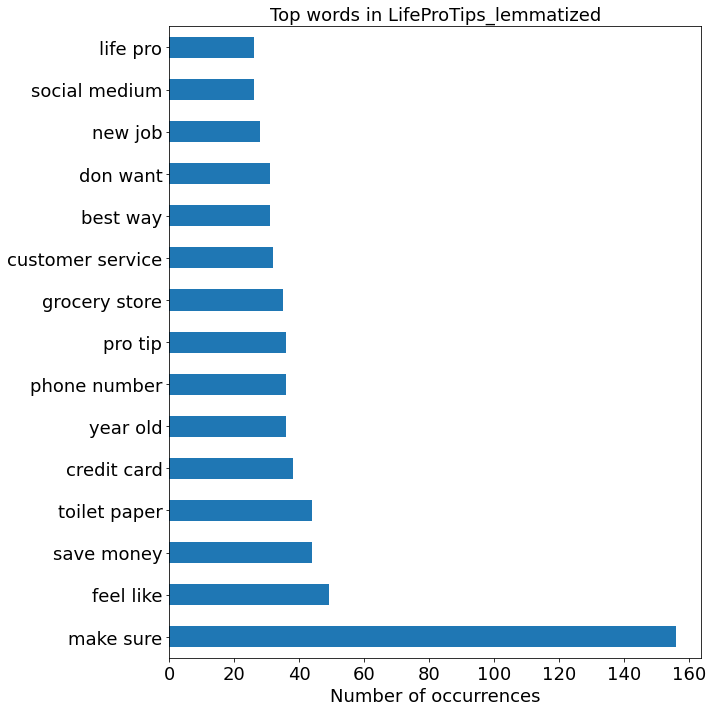

In [21]:
plot_top_words('LifeProTips_lemmatized',1, 'title_lemm', 2, 2, 15)

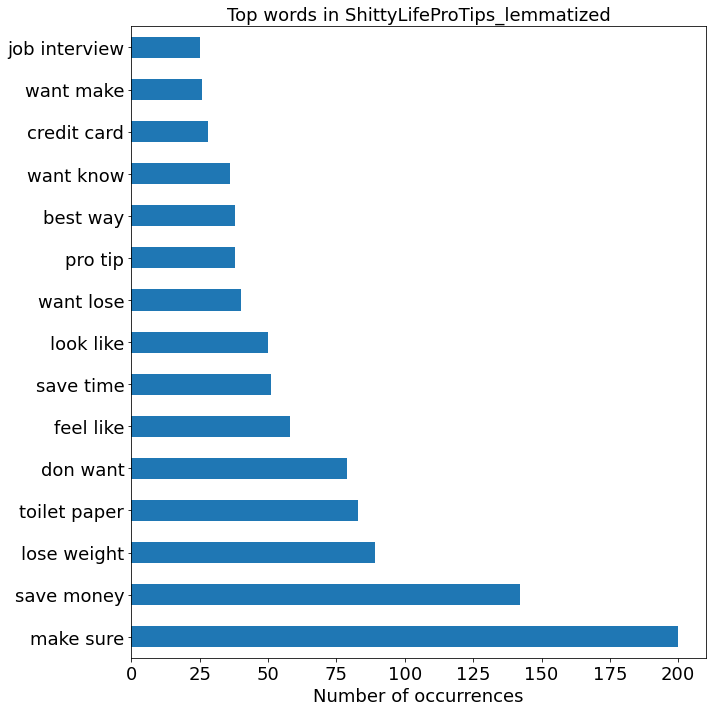

In [22]:
plot_top_words('ShittyLifeProTips_lemmatized',0, 'title_lemm', 2, 2, 15)

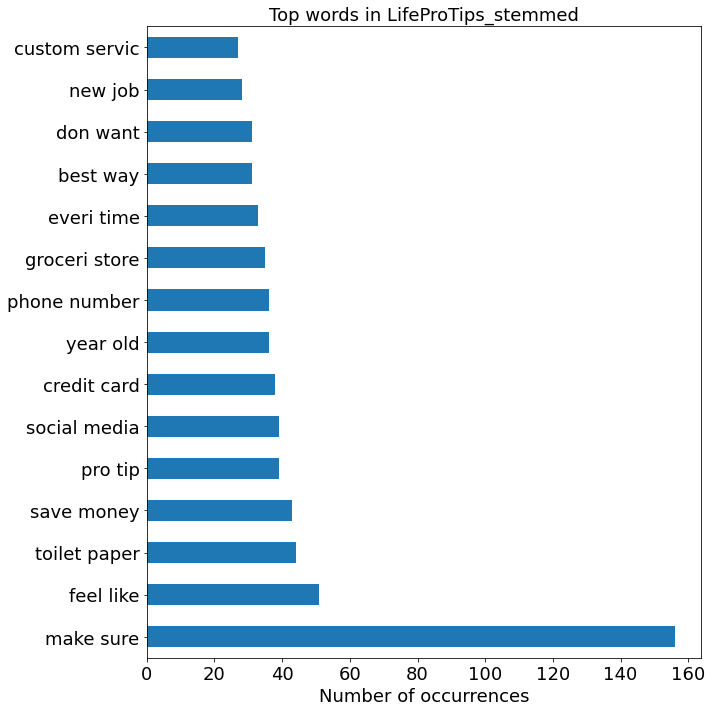

In [23]:
plot_top_words('LifeProTips_stemmed',1, 'title_stem', 2, 2, 15)

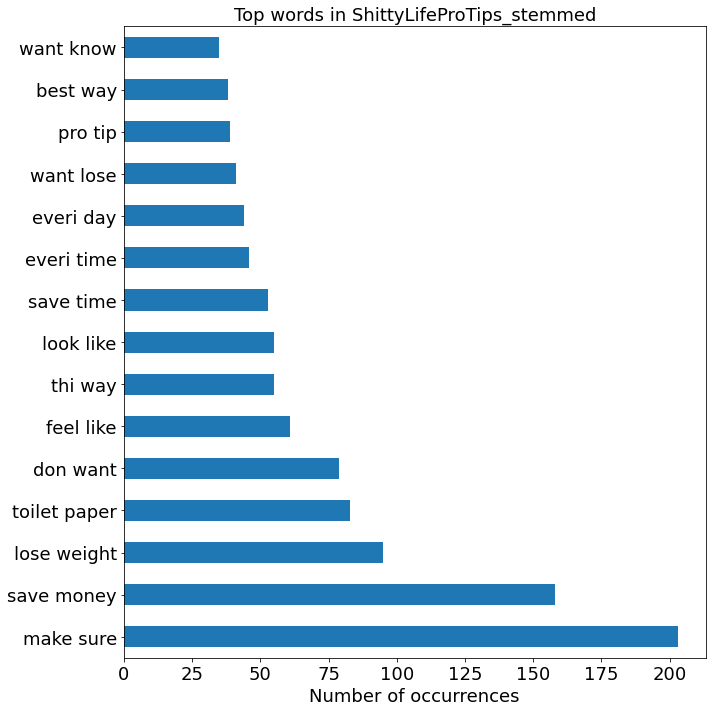

In [24]:
plot_top_words('ShittyLifeProTips_stemmed',0, 'title_stem', 2, 2, 15)

As I suspected, lemmatizing and stemming the titles did not change the top occurring bigrams too much. We will remove the lemm and stem columns for now since we will build this into the modeling in our next notebook.

Finally, we will save the cleaned titles and binarized subreddit column to a new Dataframe for modelling. 

In [25]:
df.drop(columns = ['title_lemm', 'title_stem'], inplace = True)

In [26]:
#df.to_csv('data/protips_cleaned.csv', index=False)